In [2]:
import os
import random
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import Input
from sklearn.metrics import r2_score
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from mlp_explainer.synthetic_data import SyntheticData

#### 1. Define Ground Truth Bayesian Network

In [111]:
identifier = 'experiment_1'
experiment = SyntheticData(identifier)

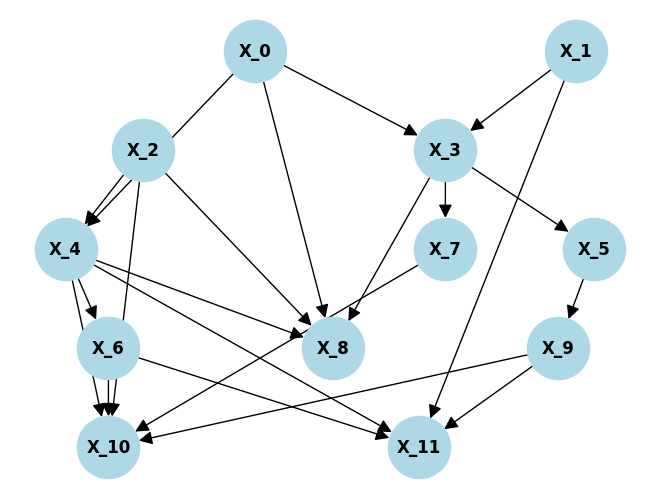

In [112]:
experiment.draw_network()

#### 2. Sample Sufficient Dataset From Ground Truth Bayesian Network

In [113]:
experiment.create_dataset()
experiment.save()

Aborting: experiment_1 dataset already exists.
Aborting: experiment_1 ground truth network already exists.


In [114]:
data = pd.read_csv(f'data/{identifier}_ground_data.csv')
data

,X_0,X_3,X_4,X_8,X_1,X_11,X_2,X_10,X_5,X_7,X_6,X_9
0,0.750165,1.785019,-0.888028,1.433829,1.557928,-1.290671,-1.525579,-0.473645,0.079971,1.410465,0.237174,-4.487023
1,-0.474873,-1.803973,0.052846,3.243156,3.182047,0.257442,-2.437506,-0.036942,2.225710,-1.255842,0.915549,-6.121457
2,0.162770,-1.982087,-0.613613,0.410640,3.128165,0.618413,-0.860671,-0.042913,-0.751101,0.417778,0.944707,-6.121450
3,1.828503,-2.270752,-5.642160,3.638501,-1.513359,-1.610955,-2.874271,-1.215246,0.884855,1.436632,-6.549039,1.464158
4,1.110116,-0.897406,-2.450025,2.106292,0.101102,0.260060,-1.795227,-0.760535,0.701033,-0.622367,-1.159809,1.454774
...,...,...,...,...,...,...,...,...,...,...,...,...
16379,-0.573055,1.016555,0.801469,0.341595,0.690390,0.510383,-0.809867,-0.601733,-0.211598,0.039443,3.132643,-1.263805
16380,-0.723023,-2.199313,2.257185,3.594207,1.933645,-1.020704,-2.740681,-0.313220,2.747566,0.936880,4.347454,-6.657429
16381,-0.667159,-1.708640,-1.425008,1.102886,1.435606,0.259247,-1.074941,-0.491883,0.468197,2.368711,-0.626016,-6.752284
16382,-0.220212,-2.539815,0.087206,1.766199,0.070661,-0.276629,-1.713071,-0.814531,0.917085,-0.860589,1.260215,1.589225


#### 3. Choose Target Variable From Bayesian Network Variables And Split Data

In [115]:
target_node = None
max_in_degree = -1
leaf_nodes = list(experiment.model.get_leaves())
in_degree_iterator = experiment.model.in_degree_iter()

for node, in_degree in in_degree_iterator:
    if node in leaf_nodes and in_degree > max_in_degree:
        target_node = node
        max_in_degree = in_degree

print(f'Target Node: {target_node}')

Target Node: X_10


In [116]:
X_columns = [column for column in data.columns.tolist() if column != target_node]

X = data[X_columns].values
y = data[target_node].values


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, shuffle=True
)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)

Train shape: (13107, 11) (13107,)
Test shape: (3277, 11) (3277,)


#### 4. Data Preprocessing

In [117]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

#### 5. Build And Train Model

In [118]:
model_filename = os.path.join("models", f"{identifier}_model.keras")
if os.path.exists(model_filename):
    print(f"Skip Stage 5 & 6: {identifier} model already exists.")

Skip Stage 5 & 6: experiment_1 model already exists.


In [119]:
model = Sequential([
    Input(shape = (X.shape[1],)),
    Dense(32, activation = 'relu'),
    Dense(32, activation = 'sigmoid'),
    Dense(8, activation = 'relu'),
    Dense(1)  
])

model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'mse')

In [120]:
history = model.fit(X, y, epochs = 50, batch_size = 32, validation_split = 0.2)

Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0185 - val_loss: 0.0051
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0045 - val_loss: 0.0045
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0043 - val_loss: 0.0044
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - loss: 0.0041 - val_loss: 0.0044
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - loss: 0.0041 - val_loss: 0.0043
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - loss: 0.0040 - val_loss: 0.0044
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 9/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 10/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 11/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - loss: 0.0040 - val_loss: 0.0042
Epoch 12/50
410/410 ━━━━━━━━━━━━

#### 6. Report and Save Model Performance

In [121]:
loss = model.evaluate(X, y)
predictions = model.predict(X)
r2 = r2_score(y, predictions)

print(f"R² score: {r2:.4f}")
print(f"Final loss: {loss}")

512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.0038
512/512 ━━━━━━━━━━━━━━━━━━━━ 0s 404us/step
R² score: 0.9588
Final loss: 0.003838282311335206


In [129]:
model_filename = os.path.join("models", f"{identifier}_model.keras")
model.save(model_filename)

#### 7. Save Random Instance To Explain

In [137]:
explaindata_filename = os.path.join("data", f"{identifier}_explaindata.npy")

if os.path.exists(explaindata_filename):
    print(f"Skip Stage 7: {identifier} explaindata already exists.")

Skip Stage 7: experiment_1 explaindata already exists.


In [145]:
X_test[0].shape

(11,)

In [146]:
num_rows = X_test.shape[0]
random_indices = np.random.choice(num_rows, size = 5, replace = False)
explaindata = X_test[random_indices]

In [148]:
np.save(explaindata_filename, explaindata)

#### 8. Method

In [151]:
model = keras.models.load_model(model_filename)

In [229]:
def zmask(instance, mean, covariance = None, eps = 1e-12):
    
    instance = np.asarray(instance)
    mean = np.asarray(mean)
    
    if covariance is None:
        raise ValueError("Provide Covariance.")
        
    sigma = np.sqrt(np.clip(np.diag(covariance), eps, np.inf))
    z_score = (instance - mean) / sigma
    
    return np.floor(abs(z_score))

In [270]:
def target_mask(model_loss, prediction, sample_prediction):
    squared_error = (prediction - sample_prediction) ** 2
    mask = squared_error // model_loss
    return mask

In [290]:
'''
1. Raw deviations.
2. Deviation binary mask.
3. Deviation n-ary mask.
'''

def data_generation(X_data, y_data, model, input_datapoint, model_loss, num_samples = 1000, scale = 1):
    
    prediction = model.predict(np.array([input_datapoint]))[0][0]    
    empirical_covariance = np.cov(X_data, rowvar = False) / scale
    samples = np.random.multivariate_normal(mean = input_datapoint, cov = empirical_covariance, size = num_samples)

    for i in range(len(samples)):
        for j in range(len(samples[i])):
            if random.random() < 0.25:
                samples[i][j] = input_datapoint[j]

    sample_predictions = model.predict(samples).reshape(num_samples,)

    for i in range(len(samples)):
        for j in range(len(samples[i])):
            samples[i][j] = samples[i][j] - input_datapoint[j]

    for i in range(len(sample_predictions)):
        sample_predictions[i] = sample_predictions[i] - prediction

    return samples

In [291]:
explain_data = np.load(explaindata_filename)
samples = data_generation(X, y, model, explain_data[0], loss, num_samples = 5, scale = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
